<style>
  body.notebook_app {
    font-family: 'Open Sans', sans-serif, 'Arial', 'Helvetica';
  }
  .project-header-custom {
    background-color: #2d6df6;
    color: white;
    padding: 25px;
    border-radius: 8px;
    margin-bottom: 30px;
    position: relative;
    font-family: 'Open Sans', sans-serif, 'Arial', 'Helvetica';
  }
  .project-header-custom h1,
  .project-header-custom p,
  .project-header-custom li {
    color: white !important;
    font-family: 'Open Sans', sans-serif, 'Arial', 'Helvetica';
  }
  .project-header-custom .logo-container {
    position: left;
    top: 15px;
    right: 15px;
  }
  .project-header-custom .logo-container img {
    width: 120px;
    height: auto;
    border-radius: 5px;
  }
</style>

<div class="project-header-custom">
  <div class="logo-container">
    <img src="../images/Logo_Prueba.png" alt="Logo del Proyecto"/>
  </div>
  <h1>BRAIN-CANCER-AI-PIPELINE: 02 - Modelo de Clasificación de Tumores Cerebrales (MRI)</h1>
  <p><strong>Autor:</strong> Juan Pablo Restrepo Urrea</p>
  <p><strong>Fecha:</strong> 2025-06-12</p>
</div>

## Resumen del Notebook

Este notebook implementa un pipeline completo para la clasificación de tumores cerebrales a partir de imágenes de resonancia magnética. Su objetivo principal es desarrollar, evaluar y analizar un modelo de Deep Learning (EfficientNet) para distinguir entre Glioma, Meningioma y Otros Tumores, y ofrecer una herramienta interactiva de inferencia.

Las fases principales cubiertas son:

1. **Configuración del entorno:** Busca y añade la carpeta raíz al `sys.path` para permitir la importación de módulos locales.
2. **Carga de librerías y módulos:** Importa todas las dependencias (`pandas`, `numpy`, `sklearn`, `torch`, funciones de `src`, etc.) y fija la semilla para garantizar reproducibilidad.
3. **Preparación de datos:** Lee el DataFrame procesado, filtra registros con valores nulos y muestra un resumen de muestras y clases.
4. **División de datos:** Realiza un split estratificado 80/20 para separar `train_val` y `test`.
5. **Validación cruzada interna:** Entrena y evalúa el modelo en K pliegues, registrando curvas de pérdida y precisión.
6. **Entrenamiento final y evaluación:** Ajusta el modelo con todo el conjunto de entrenamiento/validación y evalúa en el conjunto de prueba, generando métricas y matriz de confusión.
7. **Análisis de rendimiento avanzado:** Genera curvas ROC, Precision-Recall y curvas de calibración para examinar la capacidad de discriminación y la calidad de las probabilidades.
8. **Playground de inferencia:** Proporciona una sección interactiva para clasificar nuevas imágenes y visualizar predicciones en un grid.

In [1]:

from pathlib import Path
import sys, torch
HERE = Path().resolve()
for parent in [HERE, *HERE.parents]:
    if (parent / "src").is_dir():
        PROJECT_ROOT = parent
        break
else:
    raise RuntimeError("No se encontró carpeta 'src'")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
print("Raiz proyecto:", PROJECT_ROOT)


Raiz proyecto: C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline




## 1. Importaciones
Se importan todas las librerías y módulos necesarios, incluyendo `pandas` para manipulación de datos, `sklearn` para la división de datos y métricas, `torch` para el modelo de aprendizaje profundo, y funciones personalizadas de los módulos `src.config`, `src.utils`, `src.image_processing`, `src.model_training`, y `src.evaluation`. También se fija una semilla para asegurar la reproducibilidad de los resultados.


In [ ]:

import pandas as pd, numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader

from src.config           import BATCH_SIZE, N_FOLDS, NUM_EPOCHS, \
                                LEARNING_RATE, WEIGHT_DECAY, PROCESSED_DATA_PATH, SEED, MODEL_DIR
from src.utils            import seed_everything
from src.image_processing import MRIDataset, get_train_transforms, get_val_transforms
from src.model_training   import get_model, train_one_epoch, evaluate, plot_history, save_model
from src.evaluation       import plot_confusion_matrix, print_additional_metrics

# reproducibilidad
seed_everything()


c:\Users\juanreur\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




## 2. Carga de Datos
Se carga el DataFrame procesado en el notebook anterior (`01_EDA_and_Preprocessing.ipynb`). Para este modelo de clasificación de imágenes, solo se necesitan las columnas `condition` (la etiqueta del tipo de tumor) y `image_path` (la ruta a la imagen MRI correspondiente). Se eliminan filas con valores nulos en estas columnas.


In [3]:

df = pd.read_csv(PROCESSED_DATA_PATH)[['condition','image_path']].dropna()
print("Total muestras:", len(df), "; Clases:", df['condition'].nunique())


Total muestras: 6012 ; Clases: 3



# 
## 3. División de Datos Hold-Out (80/20)
El conjunto de datos se divide estratificadamente en un conjunto de entrenamiento/validación (80%) y un conjunto de prueba final (20%). La estratificación asegura que la proporción de clases se mantenga en ambas divisiones. El conjunto de prueba (`df_test`) se reserva y no se utiliza hasta la evaluación final del modelo.


In [4]:

outer_skf    = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED) # n_splits=5 para un 20% test
train_idx, test_idx = next(outer_skf.split(df, df['condition']))
df_trval, df_test  = df.iloc[train_idx].reset_index(drop=True), df.iloc[test_idx].reset_index(drop=True)
print(f"Hold-out → train_val: {len(df_trval)} samples | test: {len(df_test)} samples")


Hold-out → train_val: 4809 samples | test: 1203 samples




## 4. Validación Cruzada Interna (K-Fold CV)
Sobre el conjunto `df_trval` (80% de los datos), se realiza una validación cruzada de K pliegues (definido por `N_FOLDS` en la configuración). En cada pliegue:
1.  Los datos se dividen en un subconjunto de entrenamiento y un subconjunto de validación.
2.  Se crean `MRIDataset` y `DataLoader` para cada subconjunto, aplicando transformaciones de aumento de datos (data augmentation) al conjunto de entrenamiento.
3.  Se instancia un nuevo modelo, criterio de pérdida (CrossEntropyLoss) y optimizador (AdamW).
4.  El modelo se entrena durante un número definido de épocas (`NUM_EPOCHS`).
5.  Se registra el historial de pérdida de entrenamiento, pérdida de validación y precisión de validación.
6.  Se visualiza el historial de aprendizaje del pliegue y se reporta la mejor precisión de validación obtenida.
Finalmente, se calcula la media y desviación estándar de las mejores precisiones de validación obtenidas en todos los pliegues


>>> CV Fold 1/5


c:\Users\juanreur\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name efficientnet_b3a to current efficientnet_b3.
  model = create_fn(


  Epoch 1/15 → val_acc 0.9605
  Epoch 2/15 → val_acc 0.9834
  Epoch 3/15 → val_acc 0.9917
  Epoch 4/15 → val_acc 0.9906
  Epoch 5/15 → val_acc 0.9938
  Epoch 6/15 → val_acc 0.9927
  Epoch 7/15 → val_acc 0.9969
  Epoch 8/15 → val_acc 0.9969
  Epoch 9/15 → val_acc 0.9969
  Epoch 10/15 → val_acc 0.9927
  Epoch 11/15 → val_acc 0.9969
  Epoch 12/15 → val_acc 0.9958
  Epoch 13/15 → val_acc 0.9979
  Epoch 14/15 → val_acc 0.9948
  Epoch 15/15 → val_acc 0.9948


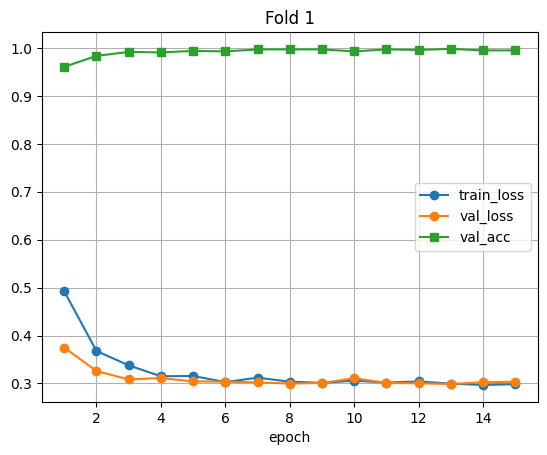

Fold 1 best acc: 0.9979

>>> CV Fold 2/5


c:\Users\juanreur\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name efficientnet_b3a to current efficientnet_b3.
  model = create_fn(


  Epoch 1/15 → val_acc 0.9771
  Epoch 2/15 → val_acc 0.9854
  Epoch 3/15 → val_acc 0.9886
  Epoch 4/15 → val_acc 0.9771
  Epoch 5/15 → val_acc 0.9938
  Epoch 6/15 → val_acc 0.9938
  Epoch 7/15 → val_acc 0.9990
  Epoch 8/15 → val_acc 0.9886
  Epoch 9/15 → val_acc 0.9896
  Epoch 10/15 → val_acc 0.9990
  Epoch 11/15 → val_acc 0.9979
  Epoch 12/15 → val_acc 0.9979
  Epoch 13/15 → val_acc 0.9958
  Epoch 14/15 → val_acc 0.9938
  Epoch 15/15 → val_acc 0.9979


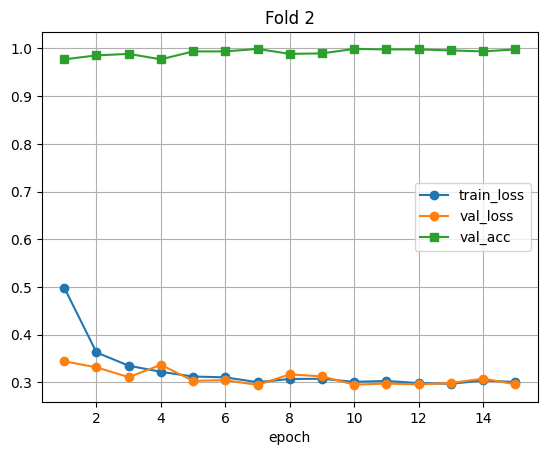

Fold 2 best acc: 0.9990

>>> CV Fold 3/5


c:\Users\juanreur\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name efficientnet_b3a to current efficientnet_b3.
  model = create_fn(


  Epoch 1/15 → val_acc 0.9647
  Epoch 2/15 → val_acc 0.9792
  Epoch 3/15 → val_acc 0.9834
  Epoch 4/15 → val_acc 0.9938
  Epoch 5/15 → val_acc 0.9938
  Epoch 6/15 → val_acc 0.9854
  Epoch 7/15 → val_acc 0.9938
  Epoch 8/15 → val_acc 0.9979
  Epoch 9/15 → val_acc 0.9896
  Epoch 10/15 → val_acc 0.9958
  Epoch 11/15 → val_acc 0.9938
  Epoch 12/15 → val_acc 0.9958
  Epoch 13/15 → val_acc 0.9906
  Epoch 14/15 → val_acc 0.9938
  Epoch 15/15 → val_acc 0.9948


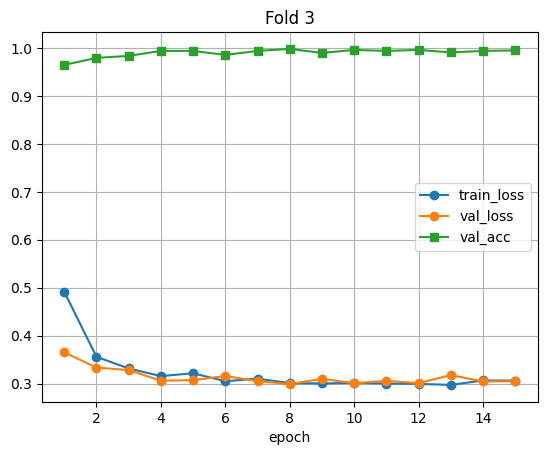

Fold 3 best acc: 0.9979

>>> CV Fold 4/5


c:\Users\juanreur\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name efficientnet_b3a to current efficientnet_b3.
  model = create_fn(


  Epoch 1/15 → val_acc 0.9813
  Epoch 2/15 → val_acc 0.9865
  Epoch 3/15 → val_acc 0.9938
  Epoch 4/15 → val_acc 0.9969
  Epoch 5/15 → val_acc 0.9948
  Epoch 6/15 → val_acc 1.0000
  Epoch 7/15 → val_acc 0.9990
  Epoch 8/15 → val_acc 1.0000
  Epoch 9/15 → val_acc 1.0000
  Epoch 10/15 → val_acc 0.9958
  Epoch 11/15 → val_acc 0.9990
  Epoch 12/15 → val_acc 0.9990
  Epoch 13/15 → val_acc 1.0000
  Epoch 14/15 → val_acc 0.9990
  Epoch 15/15 → val_acc 0.9979


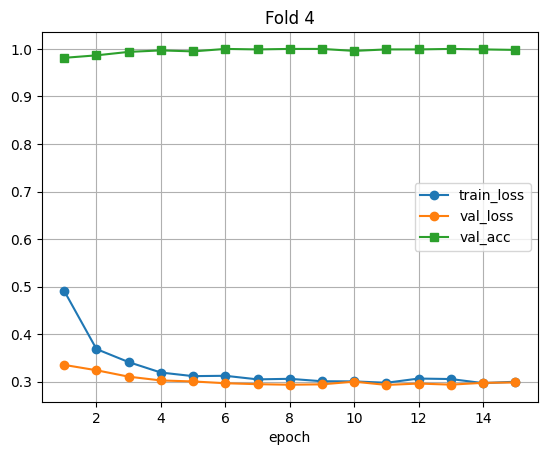

Fold 4 best acc: 1.0000

>>> CV Fold 5/5


c:\Users\juanreur\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name efficientnet_b3a to current efficientnet_b3.
  model = create_fn(


  Epoch 1/15 → val_acc 0.9802
  Epoch 2/15 → val_acc 0.9844
  Epoch 3/15 → val_acc 0.9938
  Epoch 4/15 → val_acc 0.9896
  Epoch 5/15 → val_acc 0.9958
  Epoch 6/15 → val_acc 0.9917
  Epoch 7/15 → val_acc 0.9969
  Epoch 8/15 → val_acc 0.9969
  Epoch 9/15 → val_acc 0.9938
  Epoch 10/15 → val_acc 0.9823
  Epoch 11/15 → val_acc 0.9958
  Epoch 12/15 → val_acc 0.9979
  Epoch 13/15 → val_acc 0.9969
  Epoch 14/15 → val_acc 0.9906
  Epoch 15/15 → val_acc 0.9948


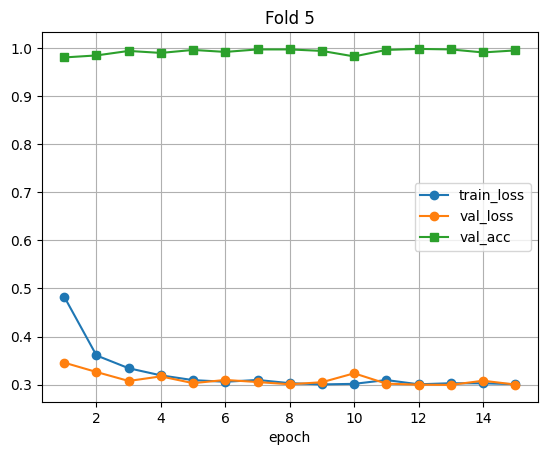

Fold 5 best acc: 0.9979

CV mean acc: 0.9985 ± 0.0008


In [5]:

inner_skf  = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
cv_hist   = []; cv_best_accs = []

for fold,(tr_idx, val_idx) in enumerate(inner_skf.split(df_trval, df_trval['condition']), 1):
    print(f"\n>>> CV Fold {fold}/{N_FOLDS}")
    ds_tr  = MRIDataset(df_trval.iloc[tr_idx], transform=get_train_transforms())
    ds_val = MRIDataset(df_trval.iloc[val_idx], transform=get_val_transforms())
    dl_tr  = DataLoader(ds_tr,  batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True)
    dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE*2, shuffle=False, pin_memory=True)

    model = get_model(num_classes=df['condition'].nunique())
    crit  = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
    opt   = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}
    best_acc = 0.0
    for epoch in range(1, NUM_EPOCHS+1):
        history['train_loss'].append(train_one_epoch(model, dl_tr, crit, opt))
        v_loss, v_acc, _, _ = evaluate   (model, dl_val, crit)
        history['val_loss'].append(v_loss)
        history['val_acc' ].append(v_acc)
        best_acc = max(best_acc, v_acc)
        print(f"  Epoch {epoch}/{NUM_EPOCHS} → val_acc {v_acc:.4f}")
    cv_hist.append(history)
    cv_best_accs.append(best_acc)

    plot_history(history, f"Fold {fold}")
    print(f"Fold {fold} best acc: {best_acc:.4f}")

print(f"\nCV mean acc: {np.mean(cv_best_accs):.4f} ± {np.std(cv_best_accs):.4f}")




## 5. Entrenamiento del Modelo Final y Evaluación en el Conjunto de Prueba
Después de la validación cruzada, se entrena un modelo final utilizando la totalidad del conjunto `df_trval` (que combina todos los datos de entrenamiento y validación de los pliegues internos). Este modelo se entrena durante el mismo número de épocas.
Posteriormente, este modelo final se evalúa sobre el conjunto de prueba `df_test` (el 20% de los datos que se reservó inicialmente). Se calcula la pérdida y la precisión en este conjunto, y se genera un reporte de clasificación detallado (precisión, recall, F1-score por clase), una matriz de confusión y métricas adicionales como el coeficiente Kappa de Cohen y el F1-score macro y ponderado.
Opcionalmente, el modelo final entrenado se guarda en disco.



--- Entrenamiento final en todo el train_val ---


c:\Users\juanreur\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name efficientnet_b3a to current efficientnet_b3.
  model = create_fn(


 Final Epoch 1/15 → train_loss 0.4712
 Final Epoch 2/15 → train_loss 0.3491
 Final Epoch 3/15 → train_loss 0.3258
 Final Epoch 4/15 → train_loss 0.3141
 Final Epoch 5/15 → train_loss 0.3042
 Final Epoch 6/15 → train_loss 0.3056
 Final Epoch 7/15 → train_loss 0.3054
 Final Epoch 8/15 → train_loss 0.3065
 Final Epoch 9/15 → train_loss 0.3006
 Final Epoch 10/15 → train_loss 0.3006
 Final Epoch 11/15 → train_loss 0.3022
 Final Epoch 12/15 → train_loss 0.2983
 Final Epoch 13/15 → train_loss 0.3033
 Final Epoch 14/15 → train_loss 0.2976
 Final Epoch 15/15 → train_loss 0.3028

--- Evaluación en Hold-out test ---
Test Loss: 0.2988 | Test Acc: 0.9975
                   precision    recall  f1-score   support

     Brain Glioma       1.00      1.00      1.00       401
Brain Meningiomas       1.00      1.00      1.00       401
      Brain Tumor       1.00      1.00      1.00       401

         accuracy                           1.00      1203
        macro avg       1.00      1.00      1.00     

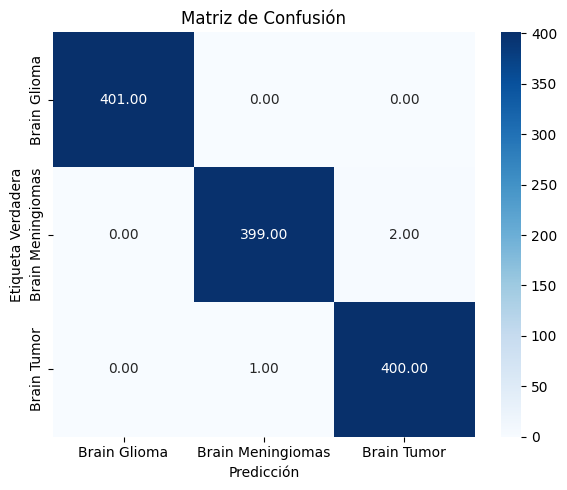

Balanced Accuracy : 0.9975
Matthews CorrCoef : 0.9963
Cohen's Kappa     : 0.9963


In [ ]:

print("\n--- Entrenamiento final en todo el train_val ---")
ds_tr_full = MRIDataset(df_trval, transform=get_train_transforms())
ds_test    = MRIDataset(df_test,  transform=get_val_transforms())
dl_tr_full = DataLoader(ds_tr_full, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True)
dl_test    = DataLoader(ds_test,    batch_size=BATCH_SIZE*2, shuffle=False, pin_memory=True)

model_final = get_model(num_classes=df['condition'].nunique())
crit_final  = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
opt_final   = torch.optim.AdamW(model_final.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

for epoch in range(1, NUM_EPOCHS+1):
    loss_tr = train_one_epoch(model_final, dl_tr_full, crit_final, opt_final)
    print(f" Final Epoch {epoch}/{NUM_EPOCHS} → train_loss {loss_tr:.4f}")

# evaluación
print("\n--- Evaluación en Hold-out test ---")
test_loss, test_acc, y_true, y_pred = evaluate(model_final, dl_test, crit_final)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
print(classification_report(y_true, y_pred, target_names=sorted(df['condition'].unique())))

# matriz y métricas adicionales
plot_confusion_matrix(y_true, y_pred, sorted(df['condition'].unique()))
print_additional_metrics(y_true, y_pred)

#guardar el modelo final
save_model(model_final, MODEL_DIR / "final_model.pth")




## 6. Análisis Adicional de Evaluación del Modelo Final
Para una comprensión más profunda del rendimiento del modelo final en el conjunto de prueba, se generan las siguientes visualizaciones:
1.  **Curvas ROC (Receiver Operating Characteristic):** Se plotea una curva ROC para cada clase (en un enfoque Uno-vs-Resto) y se calcula el AUC (Area Under the Curve) micro y macro promediado. Estas curvas ayudan a evaluar la capacidad del modelo para distinguir entre clases a diferentes umbrales de decisión.
2.  **Curvas de Precisión-Recall (Precision-Recall Curves):** Similarmente, se generan curvas PR para cada clase y se calcula el Average Precision (AP) micro y macro promediado. Estas son especialmente informativas en datasets con desbalance de clases (aunque nuestro dataset es balanceado).
3.  **Curvas de Calibración:** Se plotea una curva de calibración para cada clase. Estas curvas evalúan si las probabilidades predichas por el modelo están bien calibradas, es decir, si una predicción de probabilidad del X% corresponde realmente a que el evento ocurra el X% de las veces.


<Figure size 800x600 with 0 Axes>

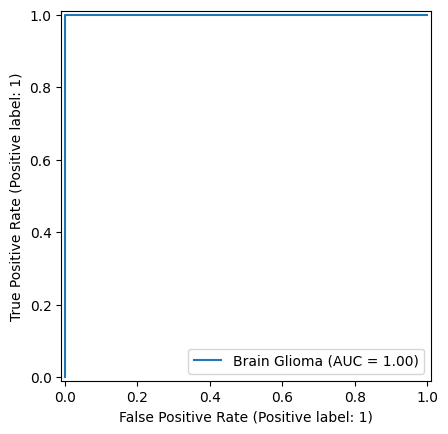

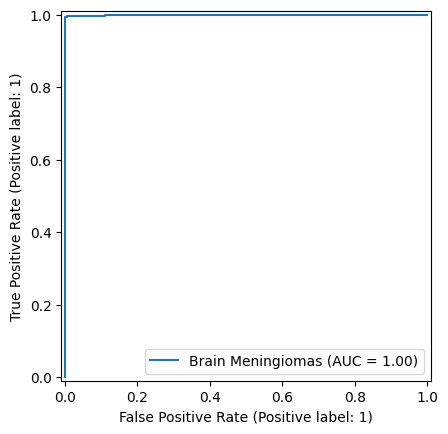

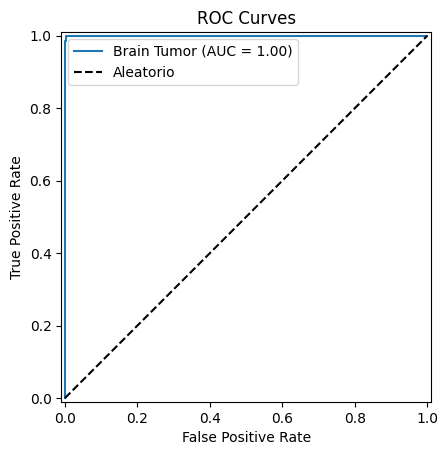

<Figure size 800x600 with 0 Axes>

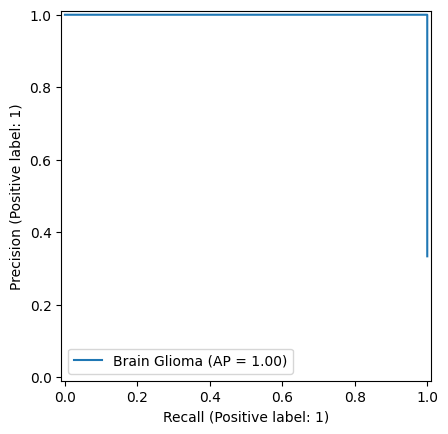

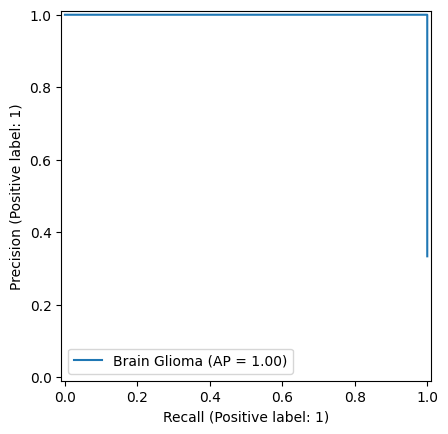

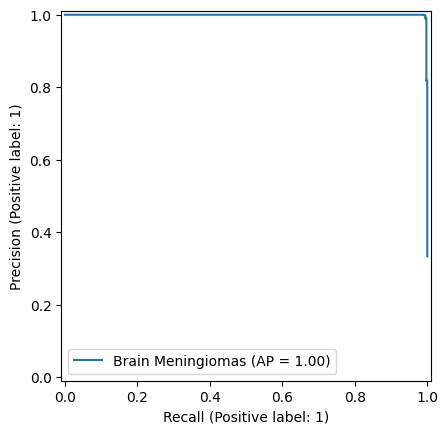

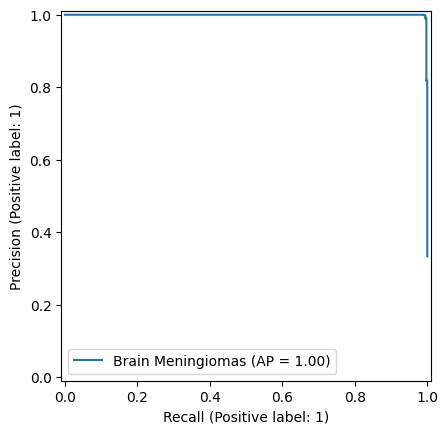

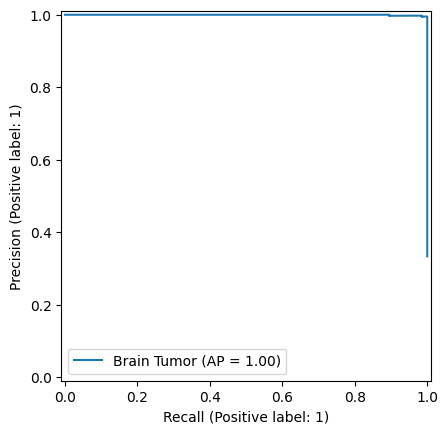

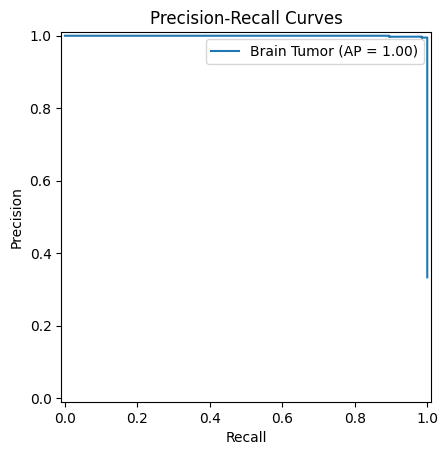

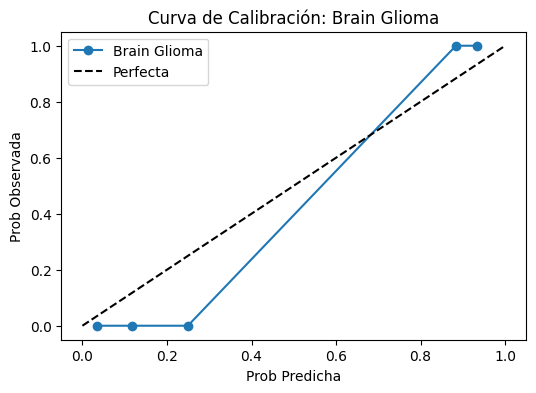

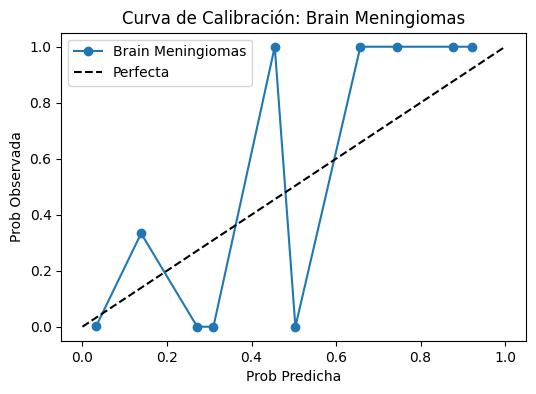

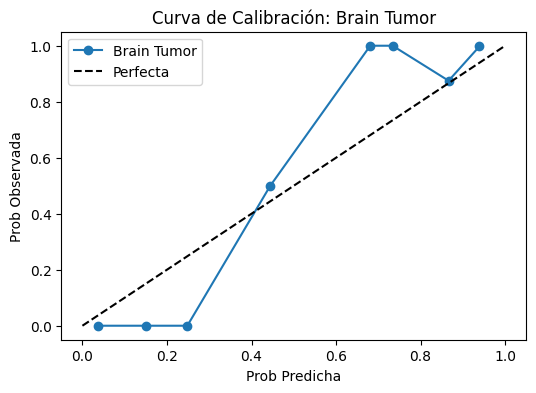

In [7]:


# ── 6. ROC, PR, Calibración ────────────────────────────────────────────────────
import numpy as np
import torch
from src.config import DEVICE # Asegúrate que DEVICE está definido en tu config.py
from src.evaluation import (
    plot_roc_curves,
    plot_precision_recall,
    plot_calibration
)

# 6.1. Obtener probabilidades sobre el test set
model_final.eval()
y_prob_list = []
with torch.no_grad():
    for xb, _ in dl_test: # dl_test fue definido en la sección anterior
        xb = xb.to(DEVICE)
        logits = model_final(xb)
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        y_prob_list.append(probs)
y_prob = np.vstack(y_prob_list)  # shape [n_samples, n_classes]



# 6.2. Curvas ROC
class_names = sorted(df['condition'].unique()) # Asegúrate que df['condition'] contiene las etiquetas correctas
plot_roc_curves(y_true, y_prob, class_names)

# 6.3. Curvas Precision-Recall
plot_precision_recall(y_true, y_prob, class_names)


# 6.4. Curvas de calibración (una por clase)
for i, cls_name in enumerate(class_names): # Usar cls_name en lugar de cls para evitar conflicto con el módulo 'cls' de windows
    # binarizamos ground-truth para la clase i
    y_true_bin = (y_true == i).astype(int) # Asumimos que y_true son índices 0, 1, 2...
    y_prob_i   = y_prob[:, i]
    plot_calibration(y_true_bin, y_prob_i, cls_name)


## Interpretación General de ROC, Precision-Recall y Calibración

Al revisar en conjunto las tres familias de curvas —**ROC**, **Precision-Recall** y **Calibración**— se extraen los siguientes hallazgos:

1. **Curvas ROC (AUC = 1.00 en las tres clases)**  
   - Cada clase (Glioma, Meningiomas, Otros Tumores) presenta una **curva ROC prácticamente en la esquina superior izquierda** y un **AUC igual a 1.00**.  
   - Esto indica que el modelo distingue **perfectamente** positivos de negativos en el conjunto de prueba.  
   - Sin embargo, un AUC tan extremo sugiere también la posibilidad de **sobreajuste**: el modelo podría haber memorizado patrones muy específicos del test set.

2. **Curvas Precision‐Recall (AP = 1.00 en las tres clases)**  
   - Los diagramas de Precision vs. Recall muestran una **curva plana en la parte alta** (Precision cercana a 1 para Recall entre 0 y 1) y un **Average Precision de 1.00**.  
   - Esto confirma que no solo separa bien clases positivas y negativas, sino que además logra mantener una precisión perfecta incluso al variar el umbral de decisión.  
   - Al igual que con el AUC, valores tan extremos pueden ser señal de que el modelo captura **demasiado fielmente** los ejemplos vistos y podría comportarse peor ante datos nuevos.

3. **Curvas de Calibración**  
   - Las tres curvas de calibración exhiben un **comportamiento escalonado “todo‐o‐nada”**: casi todas las predicciones son o muy bajas (~0) o muy altas (~1), sin probabilidad intermedia.  
   - Esta forma acentuada se aleja de la línea punteada de calibración perfecta, lo que indica que las probabilidades no reflejan la frecuencia real de eventos.  
   - **Disclaimer**: Dado que nuestra aplicación final utiliza **predicciones duras** (hard labels) —es decir, basta decidir “positivo” si p ≥ 0.5— esta falta de suavidad **no compromete la calidad de la clasificación**. Si en el futuro necesitáramos probabilidades bien calibradas (por ejemplo, para un sistema de riesgo o para combinar salidas de varios modelos), podríamos aplicar técnicas de recalibración (Platt scaling, isotonic regression, etc.) para alinear las predicciones con la tasa observada.






 ## 7. Playground de Inferencia Interactiva 

 Esta sección permite realizar inferencias interactivas utilizando el modelo entrenado. Se llama a la función `main` del script `src.infer_tumor`, que probablemente contenga una interfaz o lógica para cargar una imagen y obtener una predicción.


→ Cargando modelo   tumor_final.pth  en  cuda


c:\Users\juanreur\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name efficientnet_b3a to current efficientnet_b3.
  model = create_fn(


✔ 5 imagen(es) seleccionadas

=== Probabilidades (%) ===




Brain Glioma  Brain Meningioma  Brain Tumor
M_11.jpg           5.2         84.000000    10.900000
M_12.jpg          10.2         76.699997    13.100000
M_14.jpg           3.2         63.700001    33.099998
M_15.jpg           2.9         93.300003     3.800000
M_16.jpg           3.5         90.900002     5.600000

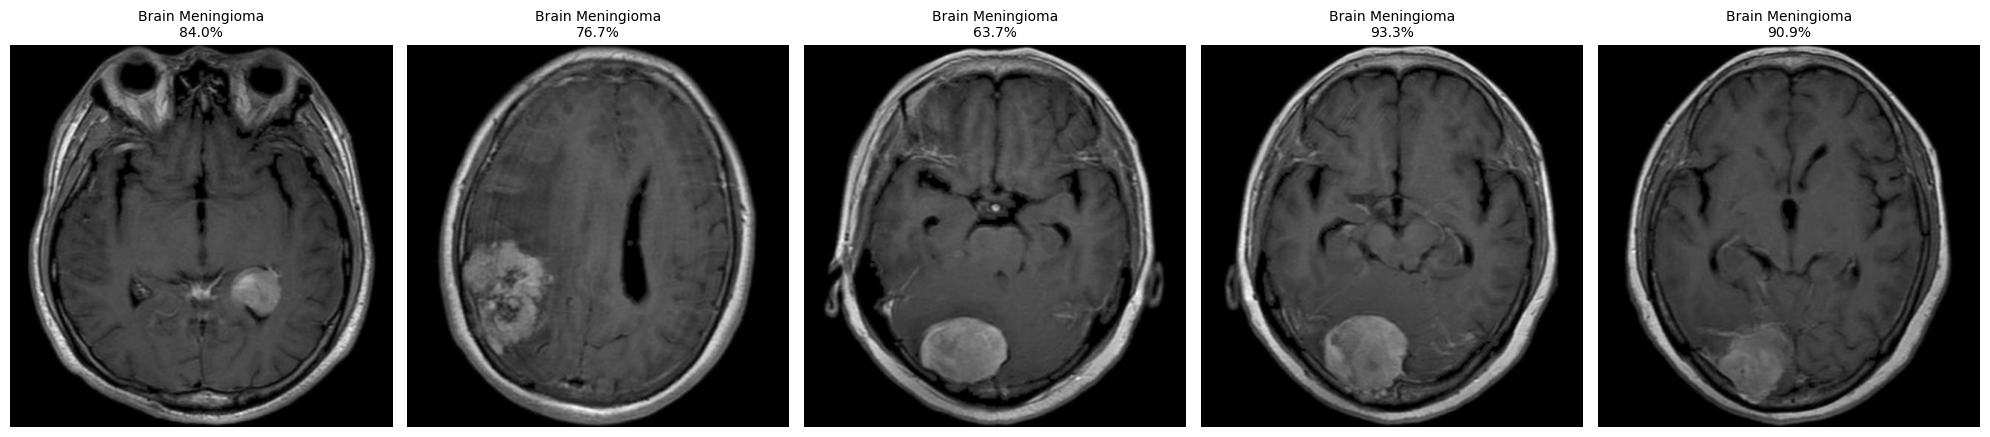

In [8]:

#Playground Inferencia de tumor
from src.infer_tumor import main # Descomentar para ejecutar
main() # Descomentar para ejecutar
x


 
 ---
 
 **Fin del Notebook 02: Modelo de Clasificación de Tumores Cerebrales.**

 El modelo ha sido entrenado, evaluado y analizado. Los resultados y el modelo guardado pueden ser utilizados en etapas posteriores del pipeline.

 ---